In [1]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import pmdarima as pm

In [2]:
!pip install pmdarima


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
acoes_train = pd.read_csv('acoes_train.csv', index_col='Date')
acoes_train.index = pd.to_datetime(acoes_train.index)
acoes_train.tail()

,index,Open,High,Low,Close,Volume,Close_1lag,Close_2lag,Close_3lag,Close_4lag,Close_5lag
Date,,,,,,,,,,,
2021-01-04 16:00:00,1450,222.53,223.00,214.81,217.69,37130139,222.42,221.68,224.15,224.96,222.75
2021-01-05 16:00:00,1451,217.26,218.52,215.70,217.90,23822953,217.69,222.42,221.68,224.15,224.96
2021-01-06 16:00:00,1452,212.17,216.49,211.94,212.25,35930653,217.90,217.69,222.42,221.68,224.15
2021-01-07 16:00:00,1453,214.04,219.34,213.71,218.29,27694480,212.25,217.90,217.69,222.42,221.68
2021-01-08 16:00:00,1454,218.68,220.58,217.03,219.62,22956206,218.29,212.25,217.90,217.69,222.42


In [4]:
acoes_test = pd.read_csv('acoes_test.csv', index_col='Date')
acoes_test.index = pd.to_datetime(acoes_test.index)
acoes_test.tail()

,index,Open,High,Low,Close,Volume,Close_1lag,Close_2lag,Close_3lag,Close_4lag,Close_5lag
Date,,,,,,,,,,,
2021-03-25 16:00:00,1506,235.30,236.94,231.57,232.34,34061853,235.46,237.58,235.99,230.35,230.72
2021-03-26 16:00:00,1507,231.55,236.71,231.55,236.48,25479853,232.34,235.46,237.58,235.99,230.35
2021-03-29 16:00:00,1508,236.59,236.80,231.88,235.24,25227455,236.48,232.34,235.46,237.58,235.99
2021-03-30 16:00:00,1509,233.53,233.85,231.10,231.85,24792012,235.24,236.48,232.34,235.46,237.58
2021-03-31 16:00:00,1510,232.91,239.10,232.39,235.77,43623471,231.85,235.24,236.48,232.34,235.46


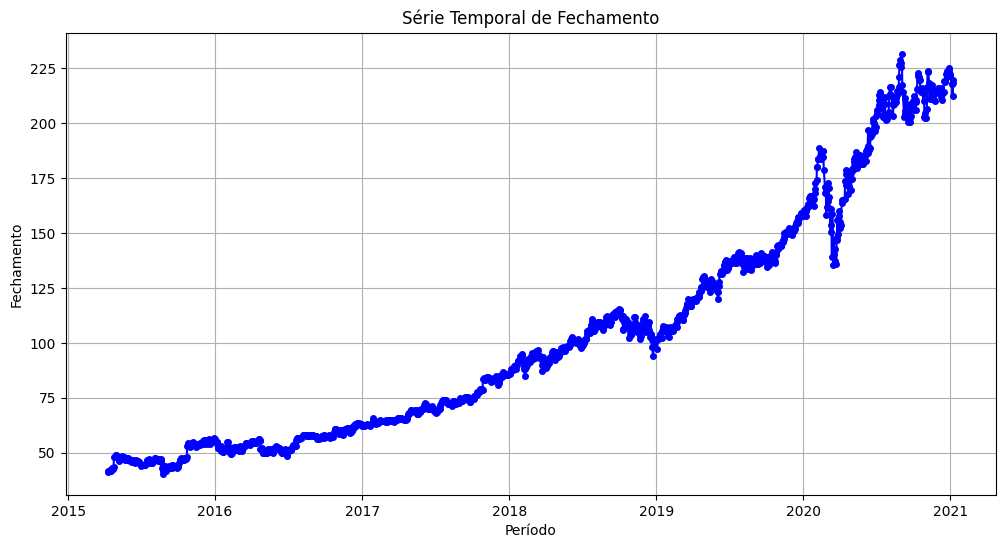

In [5]:
# Plotando o gráfico de série temporal
plt.figure(figsize=(12, 6))  # Define o tamanho da figura
plt.plot(acoes_train.index, acoes_train['Close'], color='b', linestyle='-', marker='o', markersize=4)
plt.xlabel('Período')  # Rótulo para o eixo x
plt.ylabel('Fechamento')  # Rótulo para o eixo y
plt.title('Série Temporal de Fechamento')  # Título do gráfico
plt.grid(True)  # Adiciona uma grade ao gráfico
plt.show()  # Mostra o gráfico

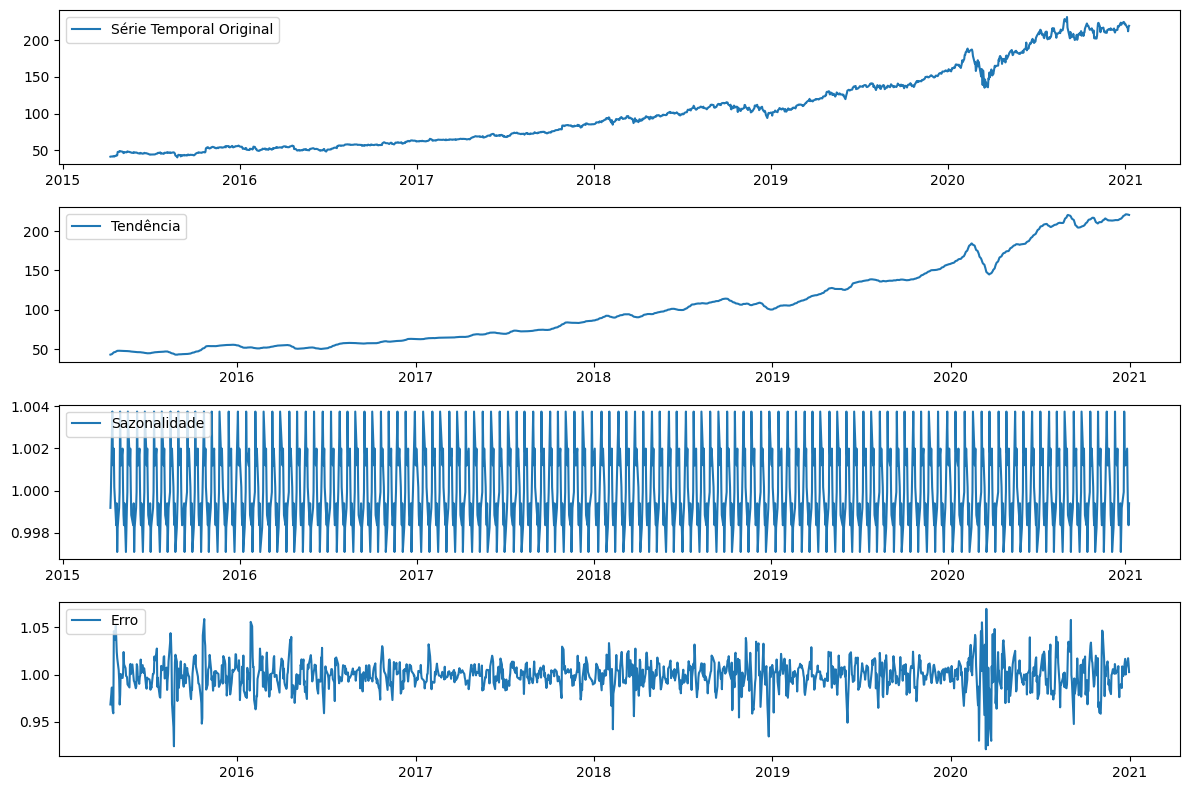

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realize a decomposição
result = seasonal_decompose(acoes_train['Close'], model='multiplicative', period=12) #additive ou multiplicative

# Obtenha as componentes da decomposição
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plotando as componentes da decomposição
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(acoes_train['Close'], label='Série Temporal Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Erro')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

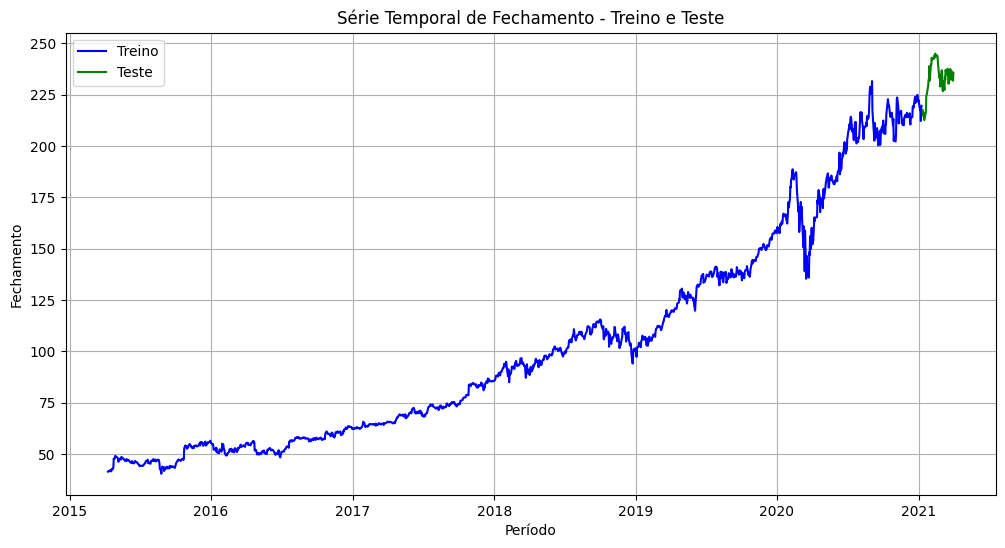

In [7]:
# Plotando as séries temporais
plt.figure(figsize=(12, 6))
plt.plot(acoes_train.index, acoes_train['Close'], label='Treino', color='blue')
plt.plot(acoes_test.index, acoes_test['Close'], label='Teste', color='green')
plt.xlabel('Período')
plt.ylabel('Fechamento')
plt.title('Série Temporal de Fechamento - Treino e Teste')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [8]:
# Passo 1: separando X e Y e normalizando os dados

X = acoes_train[["Open", "High", "Low", "Volume", "Close_1lag", "Close_2lag", "Close_3lag", "Close_4lag", "Close_5lag"]]
y = acoes_train["Close"]

# Normalização dos dados
# Normalize os dados (opcional, mas pode melhorar o desempenho da rede)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Converta os dados para o formato 3D esperado pela LSTM (samples, timesteps, features)
# Nesse caso, como temos apenas uma variável explicativa (3 features), definimos timesteps = 1.
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

In [9]:
len(X),len(y)

(1450, 1450)

In [10]:
X_lstm.shape #1450 linhas na base, por 1 data, com 9 variáveis explicativas em cada data

(1450, 1, 9)

In [11]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model1 = Sequential()
model1.add(LSTM(units=50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model1.add(Dense(units=1))

# Passo 3: Compile o modelo

model1.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history1 = model1.fit(X_lstm, y_scaled, epochs=200, batch_size=32)

Epoch 1/200
46/46 [==============================] - 1s 957us/step - loss: 0.0738
Epoch 2/200
46/46 [==============================] - 0s 872us/step - loss: 0.0035
Epoch 3/200
46/46 [==============================] - 0s 866us/step - loss: 0.0010
Epoch 4/200
46/46 [==============================] - 0s 867us/step - loss: 5.3000e-04
Epoch 5/200
46/46 [==============================] - 0s 844us/step - loss: 3.7320e-04
Epoch 6/200
46/46 [==============================] - 0s 869us/step - loss: 2.8168e-04
Epoch 7/200
46/46 [==============================] - 0s 856us/step - loss: 2.5165e-04
Epoch 8/200
46/46 [==============================] - 0s 865us/step - loss: 2.3319e-04
Epoch 9/200
46/46 [==============================] - 0s 842us/step - loss: 2.1740e-04
Epoch 10/200
46/46 [==============================] - 0s 859us/step - loss: 2.0026e-04
Epoch 11/200
46/46 [==============================] - 0s 877us/step - loss: 1.8632e-04
Epoch 12/200
46/46 [==============================] - 0s 868us/s

In [12]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model2 = Sequential()
model2.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model2.add(Dense(units=1))

# Passo 3: Compile o modelo

model2.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history2 = model2.fit(X_lstm, y_scaled, epochs=200, batch_size=8)

Epoch 1/200
182/182 [==============================] - 1s 923us/step - loss: 0.0218
Epoch 2/200
182/182 [==============================] - 0s 910us/step - loss: 2.2054e-04
Epoch 3/200
182/182 [==============================] - 0s 918us/step - loss: 1.6299e-04
Epoch 4/200
182/182 [==============================] - 0s 913us/step - loss: 1.4136e-04
Epoch 5/200
182/182 [==============================] - 0s 912us/step - loss: 1.2701e-04
Epoch 6/200
182/182 [==============================] - 0s 913us/step - loss: 1.1594e-04
Epoch 7/200
182/182 [==============================] - 0s 914us/step - loss: 1.1658e-04
Epoch 8/200
182/182 [==============================] - 0s 914us/step - loss: 1.0631e-04
Epoch 9/200
182/182 [==============================] - 0s 911us/step - loss: 9.2397e-05
Epoch 10/200
182/182 [==============================] - 0s 906us/step - loss: 9.6810e-05
Epoch 11/200
182/182 [==============================] - 0s 916us/step - loss: 8.1091e-05
Epoch 12/200
182/182 [============

In [13]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model3 = Sequential()
model3.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model3.add(Dense(units=1))

# Passo 3: Compile o modelo

model3.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history3 = model3.fit(X_lstm, y_scaled, epochs=500, batch_size=16)

Epoch 1/500
91/91 [==============================] - 1s 995us/step - loss: 0.0313
Epoch 2/500
91/91 [==============================] - 0s 956us/step - loss: 3.9012e-04
Epoch 3/500
91/91 [==============================] - 0s 983us/step - loss: 2.1496e-04
Epoch 4/500
91/91 [==============================] - 0s 996us/step - loss: 1.6603e-04
Epoch 5/500
91/91 [==============================] - 0s 996us/step - loss: 1.4828e-04
Epoch 6/500
91/91 [==============================] - 0s 1ms/step - loss: 1.2979e-04
Epoch 7/500
91/91 [==============================] - 0s 992us/step - loss: 1.2634e-04
Epoch 8/500
91/91 [==============================] - 0s 1ms/step - loss: 1.2286e-04
Epoch 9/500
91/91 [==============================] - 0s 1ms/step - loss: 1.1467e-04
Epoch 10/500
91/91 [==============================] - 0s 1ms/step - loss: 1.0734e-04
Epoch 11/500
91/91 [==============================] - 0s 992us/step - loss: 1.0524e-04
Epoch 12/500
91/91 [==============================] - 0s 1ms/ste

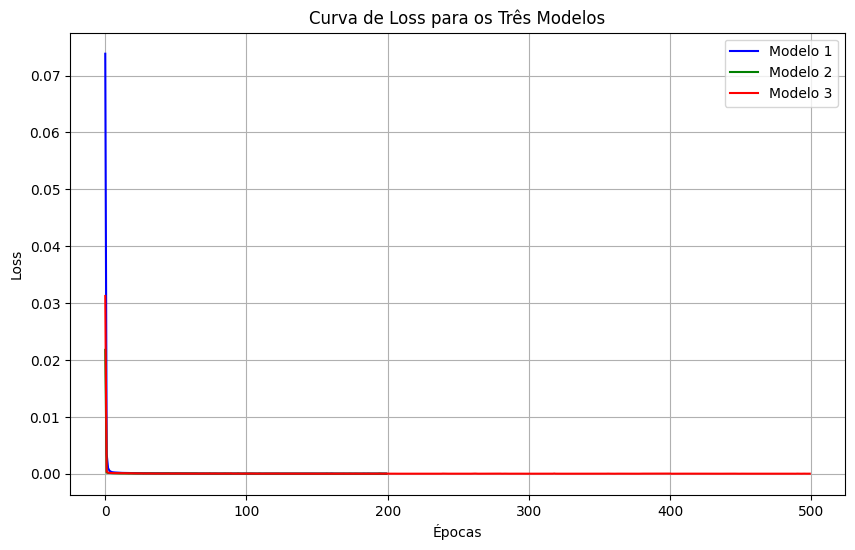

In [14]:
# Supondo que você tenha os objetos "history1", "history2" e "history3", que contêm informações sobre o treinamento dos três modelos.

# Plotando as curvas de loss
plt.figure(figsize=(10, 6))

plt.plot(history1.history['loss'], label='Modelo 1', color='blue')
plt.plot(history2.history['loss'], label='Modelo 2', color='green')
plt.plot(history3.history['loss'], label='Modelo 3', color='red')

plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Loss para os Três Modelos')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Passo 1: Pré-processamento dos novos dados de teste

# Divida os dados em variáveis de entrada (X) e variável de saída (y), similar ao que você fez para os dados de treinamento.
X_test = acoes_test[["Open", "High", "Low", "Volume", "Close_1lag", "Close_2lag", "Close_3lag", "Close_4lag", "Close_5lag"]]

# Normalize os dados usando o mesmo scaler que você usou para os dados de treinamento.
X_test_scaled = scaler_X.transform(X_test)

# Converta os dados para o formato 3D esperado pela LSTM
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Passo 2: Fazer previsões com o modelo LSTM

# Use o método predict para fazer as previsões
y_pred_scaled1 = model1.predict(X_test_lstm)
y_pred_scaled2 = model2.predict(X_test_lstm)
y_pred_scaled3 = model3.predict(X_test_lstm)

# Como o modelo retorna as previsões em escala, desfaça a normalização para obter as previsões reais
y_pred1 = scaler_y.inverse_transform(y_pred_scaled1)
y_pred2 = scaler_y.inverse_transform(y_pred_scaled2)
y_pred3 = scaler_y.inverse_transform(y_pred_scaled3)

2/2 [==============================] - 0s 1ms/step


In [16]:
# Calcule o RMSE para cada modelo
rmse_model1 = np.sqrt(np.mean((np.array(acoes_test['Close']) - y_pred1) ** 2))
rmse_model2 = np.sqrt(np.mean((np.array(acoes_test['Close']) - y_pred2) ** 2))
rmse_model3 = np.sqrt(np.mean((np.array(acoes_test['Close']) - y_pred3) ** 2))

print('RMSE Modelo 1:', rmse_model1)
print('RMSE Modelo 2:', rmse_model2)
print('RMSE Modelo 3:', rmse_model3)

RMSE Modelo 1: 11.491952659711643
RMSE Modelo 2: 11.685344524121723
RMSE Modelo 3: 11.518268022660422


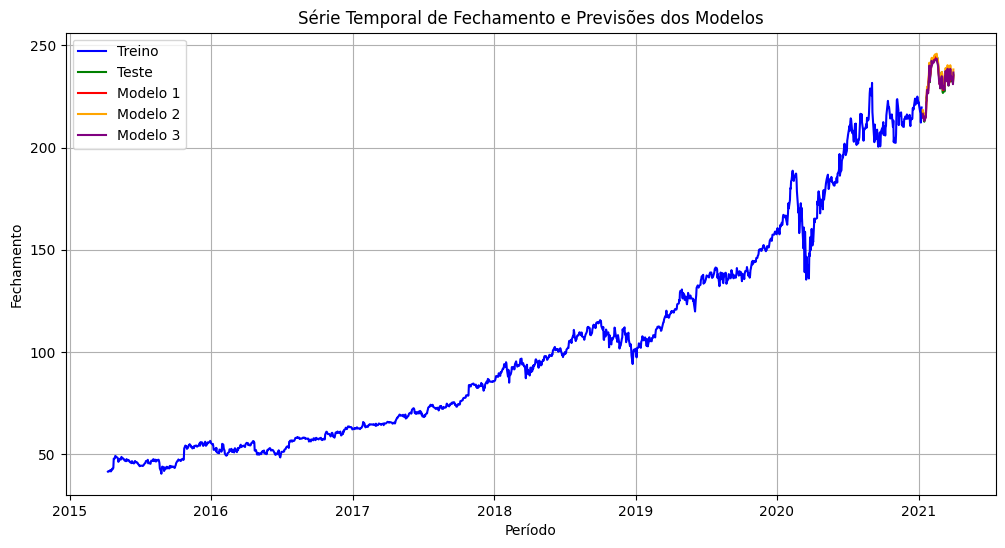

In [17]:
# Plotando a série temporal da coluna "meantemp" da base de treino e teste
plt.figure(figsize=(12, 6))
plt.plot(acoes_train.index, acoes_train['Close'], label='Treino', color='blue')
plt.plot(acoes_test.index, acoes_test['Close'], label='Teste', color='green')

# Plotando as previsões dos modelos em cores diferentes
plt.plot(acoes_test.index, y_pred1, label='Modelo 1', color='red')
plt.plot(acoes_test.index, y_pred2, label='Modelo 2', color='orange')
plt.plot(acoes_test.index, y_pred3, label='Modelo 3', color='purple')

plt.xlabel('Período')
plt.ylabel('Fechamento')
plt.title('Série Temporal de Fechamento e Previsões dos Modelos')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [18]:
acoes_test['Modelo 1'] = y_pred1
acoes_test['Modelo 2'] = y_pred2
acoes_test['Modelo 3'] = y_pred3

acoes_test

,index,Open,High,Low,Close,Volume,Close_1lag,Close_2lag,Close_3lag,Close_4lag,Close_5lag,Modelo 1,Modelo 2,Modelo 3
Date,,,,,,,,,,,,,,
2021-01-11 16:00:00,1455,218.47,218.91,216.73,217.49,23047029,219.62,218.29,212.25,217.90,217.69,217.834778,218.378220,216.564606
2021-01-12 16:00:00,1456,216.50,217.10,213.32,214.93,23249336,217.49,219.62,218.29,212.25,217.90,215.865067,216.385651,214.420227
2021-01-13 16:00:00,1457,214.02,216.76,213.93,216.34,20087080,214.93,217.49,219.62,218.29,212.25,215.894760,217.021042,215.596573
2021-01-14 16:00:00,1458,215.91,217.46,212.74,213.02,29346737,216.34,214.93,217.49,219.62,218.29,215.176315,215.920105,214.022980
2021-01-15 16:00:00,1459,213.52,214.51,212.03,212.65,31746512,213.02,216.34,214.93,217.49,219.62,213.705704,214.749298,213.040222
2021-01-19 16:00:00,1460,213.75,216.98,212.63,216.44,30480859,212.65,213.02,216.34,214.93,217.49,214.990036,216.478149,215.002686
2021-01-20 16:00:00,1461,217.70,225.79,217.29,224.34,37777260,216.44,212.65,213.02,216.34,214.93,220.610840,223.108597,222.174988
2021-01-21 16:00:00,1462,224.70,226.30,222.42,224.97,30749553,224.34,216.44,212.65,213.02,216.34,223.861160,224.837616,222.941406
2021-01-22 16:00:00,1463,227.08,230.07,225.80,225.95,30172663,224.97,224.34,216.44,212.65,213.02,228.169708,229.829422,228.276459


In [19]:
# Crie o modelo AutoARIMA e encontre o melhor modelo ARIMA automaticamente
model4 = pm.auto_arima(np.array(acoes_train['Close']), exogenous=np.array(acoes_train[["Open", "High", "Low", "Volume", "Close_1lag", "Close_2lag", "Close_3lag", "Close_4lag", "Close_5lag"]]), seasonal=True, m=28)  # O parâmetro "m" representa a frequência da sazonalidade (7 dias por semana)

# Faça as previsões usando o modelo treinado
y_pred4 = model4.predict(n_periods=len(np.array(acoes_test['Close'])), exogenous=np.array(acoes_test[["Open", "High", "Low", "Volume", "Close_1lag", "Close_2lag", "Close_3lag", "Close_4lag", "Close_5lag"]]))

In [20]:
# Calcule o RMSE para avaliar o desempenho do modelo
rmse = mean_squared_error(np.array(acoes_test['Close']), y_pred4, squared=False)
print(f"RMSE do AutoARIMA: {rmse}")

RMSE do AutoARIMA: 13.045158461685972


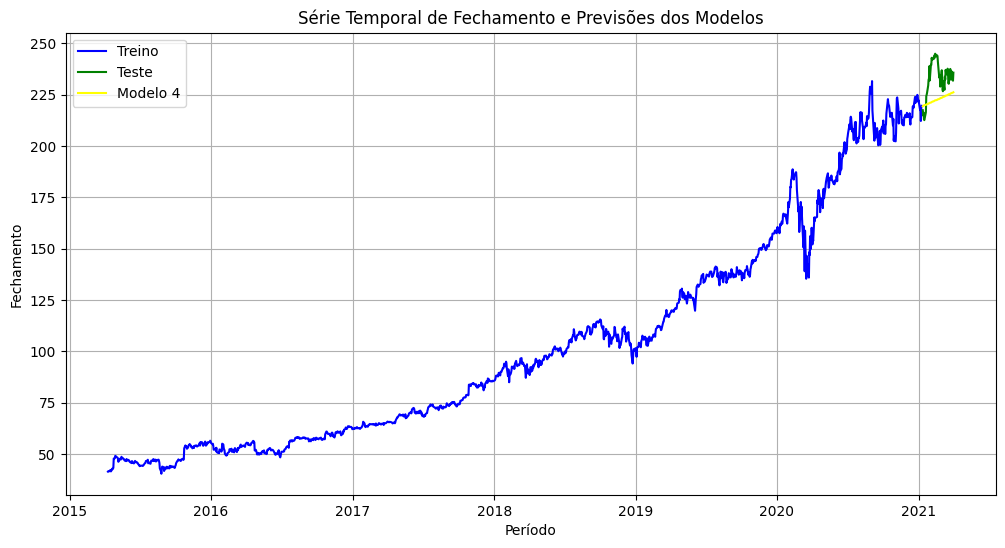

In [21]:
# Plotando a série temporal da coluna "meantemp" da base de treino e teste
plt.figure(figsize=(12, 6))
plt.plot(acoes_train.index, acoes_train['Close'], label='Treino', color='blue')
plt.plot(acoes_test.index, acoes_test['Close'], label='Teste', color='green')

# Plotando as previsões dos modelos em cores diferentes
plt.plot(acoes_test.index, y_pred4, label='Modelo 4', color='yellow')

plt.xlabel('Período')
plt.ylabel('Fechamento')
plt.title('Série Temporal de Fechamento e Previsões dos Modelos')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()